# Table of Contents

 - 1 Goal
 - 2 importing the libaries 
 - 3 Reading the data
 - 4 Plot settings
 - 5 Defining functions
 - 6 EDA
 - 7 Preparing data for ML
 - 8 ML models<font color='blue'>
   - 8.1 Logistic Regression
   - 8.2 Multinomial Naive Bayes
   - 8.3 Neural network </font>
- 9 Model comparison
- 10 Conclusion

# Goal

Classification of a gene family based on the dna sequence.

# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
# Load models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Reading the data

In [2]:
human_df=pd.read_table('human.txt')  # human data
human_df.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [3]:
chimp_df=pd.read_table('chimpanzee.txt') # chimpanzee data
chimp_df.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [4]:
dog_df=pd.read_table('dog.txt')   # dog data
dog_df.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


# Plot settings

In [5]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['figure.figsize'] = 7,4
sns.set_style('ticks')

# Defining functions

In [6]:
def normalized_confusion_matrix(y_test, conf_mat, model,species):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = conf_mat/counts
    plt.figure(figsize=(12,6))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,annot_kws={'size':20},lw=2, cbar=True, cbar_kws={'label':'% Class accuracy'})
    plt.title(f'Confusion Matrix ({model}-{species})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20) ##colorbar label
    cax = plt.gcf().axes[-1]  ##colorbar ticks
    cax.tick_params(labelsize=20) ## colorbar ticks
    plt.savefig(f'confusion-matrix-{model}-{species}.png',dpi=300)

In [7]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

# EDA

In [8]:
print("dimension of human data: {}".format(human_df.shape))
print("dimension of chimpanzee data: {}".format(chimp_df.shape))
print("dimension of dog data: {}".format(dog_df.shape))

dimension of human data: (4380, 2)
dimension of chimpanzee data: (1682, 2)
dimension of dog data: (820, 2)


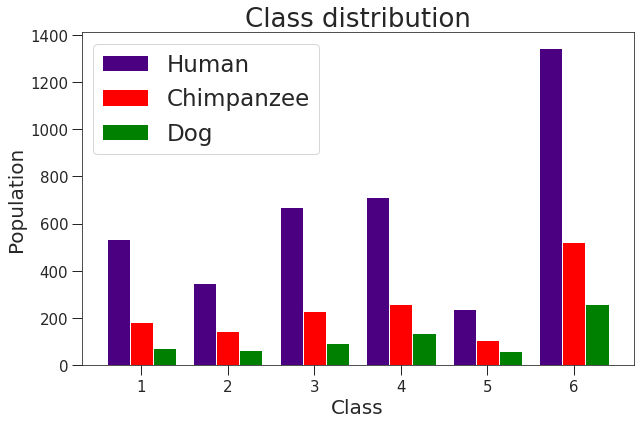

In [9]:
plt.figure(figsize=(9,6))
colors = ['indigo', 'r','g']
names=['Human','Chimpanzee','Dog']
bins= np.arange(7)+0.5
plt.hist([human_df['class'],chimp_df['class'],dog_df['class']],bins,color=colors,label=names)
plt.xlabel('Class')
plt.ylabel('Population')
plt.title('Class distribution',size=26)
plt.legend()
plt.tight_layout()
plt.savefig('Class_distribution.png',dpi=300)

# Preparing data for ML

- A k-mer is just a sequence of k characters in a string (or nucleotides in a DNA sequence). Now, it is important to remember that to get all k-mers from a sequence you need to get the first k characters, then move just a single character for the start of the next k-mer and so on. Effectively, this will create sequences that overlap in k-1 positions.

In [10]:
#Using K-mers, which decomposes a sequence into its k-mers and 
#allows this set of fixed-size chunks to be analysed rather than the sequence.

def getKmers(sequence, size=6): # size=6 
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [11]:
# Try to convert our data sequences into short overlapping k-mers of legth 6 
# Lets do that for each species of data we have using our getKmers function

human_df['words'] = human_df.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_df.drop('sequence', axis=1)
chimp_df['words'] = chimp_df.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp_data = chimp_df.drop('sequence', axis=1)
dog_df['words'] = dog_df.apply(lambda x: getKmers(x['sequence']), axis=1)
dog_data = dog_df.drop('sequence', axis=1)

In [12]:
human_data[:].head() 

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


Using scikit-learn NLP to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. 
We can also make a y variable to hold the class labels.

In [13]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_human = human_data.iloc[:, 0].values  

In [14]:
human_texts[0]  

'atgccc tgcccc gcccca ccccaa cccaac ccaact caacta aactaa actaaa ctaaat taaata aaatac aatact atacta tactac actacc ctaccg taccgt accgta ccgtat cgtatg gtatgg tatggc atggcc tggccc ggccca gcccac cccacc ccacca caccat accata ccataa cataat ataatt taatta aattac attacc ttaccc tacccc accccc ccccca ccccat cccata ccatac catact atactc tactcc actcct ctcctt tcctta ccttac cttaca ttacac tacact acacta cactat actatt ctattc tattcc attcct ttcctc tcctca cctcat ctcatc tcatca catcac atcacc tcaccc caccca acccaa cccaac ccaact caacta aactaa actaaa ctaaaa taaaaa aaaaat aaaata aaatat aatatt atatta tattaa attaaa ttaaac taaaca aaacac aacaca acacaa cacaaa acaaac caaact aaacta aactac actacc ctacca taccac accacc ccacct caccta acctac cctacc ctacct tacctc acctcc cctccc ctccct tccctc ccctca cctcac ctcacc tcacca caccaa accaaa ccaaag caaagc aaagcc aagccc agccca gcccat cccata ccataa cataaa ataaaa taaaaa aaaaat aaaata aaataa aataaa ataaaa taaaaa aaaaaa aaaaat aaaatt aaatta aattat attata ttataa tataac ataaca taacaa aacaaa acaaa

In [15]:
y_human # y_data contains the class

array([4, 4, 3, ..., 6, 6, 6])

In [16]:
# Same procedure for chimpanzee and dog

chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_chimp = chimp_data.iloc[:, 0].values                       
dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_dog = dog_data.iloc[:, 0].values                           

Creating the Bag of Words model using CountVectorizer(), this is equivalent to k-mer counting.
The n-gram size of 4 was previously determined by testing.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [18]:
print(X.shape)         # For Human
print(X_chimp.shape)   # For Chimpanzee
print(X_dog.shape)     # For Dog

(4380, 232414)
(1682, 232414)
(820, 232414)


## Splitting the data


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_human, test_size = 0.20, random_state=42, stratify=y_human)

Stratifying preserves the proportion of how data is distributed in the target column and depicts that same proportion of distribution in the train_test_split.

In [20]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


# ML models

##  Logistic regression

In [21]:
Clist=[1] # to find the the best value of C, Also one can use GridSearchCV from sklearn

for C in Clist : 

    logreg = LogisticRegression(C=C,solver='newton-cg').fit(X_train, y_train) #keeping C=1 a
    y_train_pred = logreg.predict(X_train)
    y_pred = logreg.predict(X_test)

    print('C : {} Training set accuracy: {:.3f}'.format(C,accuracy_score(y_train, y_train_pred)))
    print('C : {} Test set accuracy: {:.3f}'.format(C,accuracy_score(y_test, y_pred)))
    print('\n')

C : 1 Training set accuracy: 0.999
C : 1 Test set accuracy: 0.932




In [22]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.999 
precision = 0.940 
recall = 0.932 
f1 = 0.932


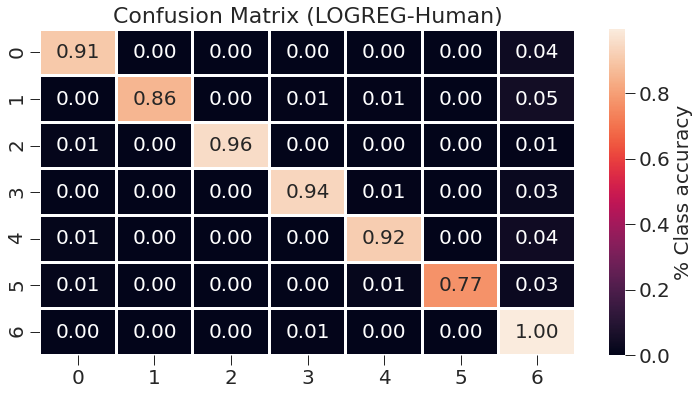

In [23]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'LOGREG','Human')

In [24]:
k_fold_logreg_accuracy = cross_val_score(logreg, X, y_human, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)) ##5-fold cross validation
k_fold_logreg_f1 = cross_val_score(logreg, X, y_human, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True), scoring='f1_macro') ##5-fold cross validation

In [25]:
print(f'Average accuracy after 5 fold cross validation :{k_fold_logreg_accuracy.mean().round(2)} +/- {k_fold_logreg_accuracy.std().round(2)}')
print(f'Average F1-score after 5 fold cross validation :{k_fold_logreg_f1.mean().round(2)} +/- {k_fold_logreg_f1.std().round(2)}')

Average accuracy after 5 fold cross validation :0.94 +/- 0.0
Average F1-score after 5 fold cross validation :0.94 +/- 0.01


### Predictions for the chimpanzee and dog dna sequences

#### Chimpanzee

Performace on the Chimpanzee sequence:
accuracy = 0.999 
precision = 0.988 
recall = 0.988 
f1 = 0.988


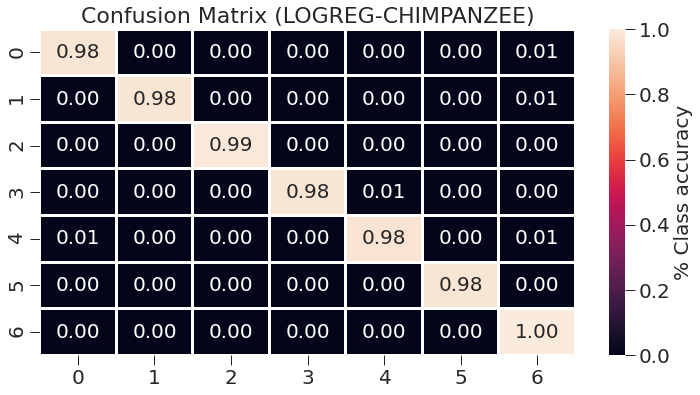

In [26]:
y_pred_chimp=logreg.predict(X_chimp)
conf_mat = confusion_matrix(y_chimp,y_pred_chimp)
normalized_confusion_matrix(y_chimp,conf_mat,'LOGREG','CHIMPANZEE')
accuracy, precision, recall, f1 = get_metrics(y_chimp, y_pred_chimp)
print('Performace on the Chimpanzee sequence:')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

#### DOG

Performace on the Dog sequence:
accuracy = 0.999 
precision = 0.931 
recall = 0.922 
f1 = 0.922


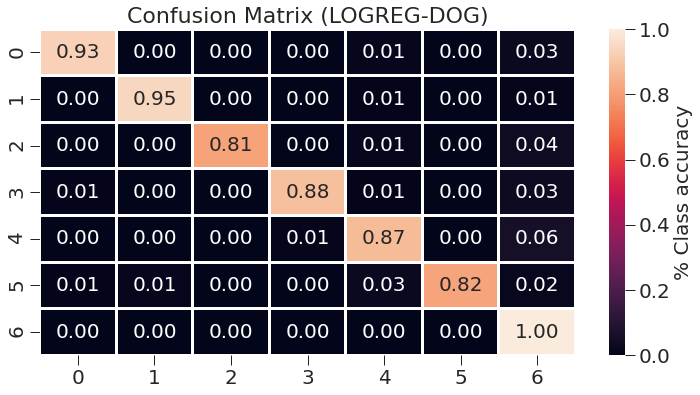

In [27]:
y_pred_dog=logreg.predict(X_dog)
conf_mat = confusion_matrix(y_dog,y_pred_dog)
normalized_confusion_matrix(y_dog,conf_mat,'LOGREG','DOG')
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_dog)
print('Performace on the Dog sequence:')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Multinomial Naive Bayes

 The alpha parameter was determined by grid search previously

In [28]:
mnb = MultinomialNB(alpha=1).fit(X_train, y_train) 
y_train_pred = mnb.predict(X_train)
y_pred = mnb.predict(X_test)

print('Training set accuracy: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Test set accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('\n')

Training set accuracy: 0.999
Test set accuracy: 0.983




accuracy = 0.999 
precision = 0.983 
recall = 0.983 
f1 = 0.983


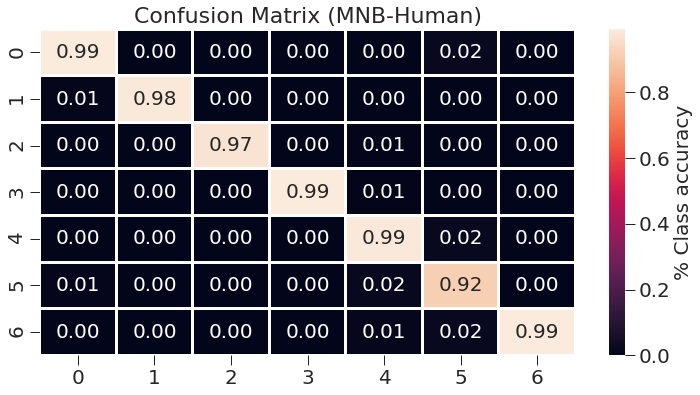

In [29]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'MNB','Human')
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

In [30]:
k_fold_mnb_accuracy = cross_val_score(mnb, X, y_human, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)) ##5-fold cross validation
k_fold_mnb_f1 = cross_val_score(mnb, X, y_human, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True), scoring='f1_macro') ##5-fold cross validation
print(f'Average accuracy after 5 fold cross validation : {k_fold_mnb_accuracy.mean().round(2)} +/- {k_fold_mnb_accuracy.std().round(2)}')
print(f'Average F1-score after 5 fold cross validation : {k_fold_mnb_f1.mean().round(2)} +/- {k_fold_mnb_f1.std().round(2)}')

Average accuracy after 5 fold cross validation : 0.97 +/- 0.01
Average F1-score after 5 fold cross validation : 0.97 +/- 0.01


### Predictions for the chimpanzee and dog dna sequences
#### Chimpanzee

Performace on the Chimpanzee sequence:
accuracy = 0.999 
precision = 0.992 
recall = 0.992 
f1 = 0.992


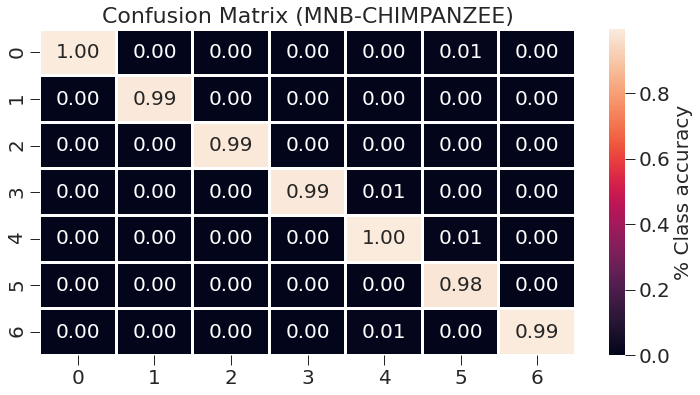

In [31]:
y_pred_chimp=mnb.predict(X_chimp)
conf_mat = confusion_matrix(y_chimp,y_pred_chimp)
normalized_confusion_matrix(y_chimp,conf_mat,'MNB','CHIMPANZEE')
accuracy, precision, recall, f1 = get_metrics(y_chimp, y_pred_chimp)
print('Performace on the Chimpanzee sequence:')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

#### Dog

Performace on the Dog sequence:
accuracy = 0.999 
precision = 0.957 
recall = 0.952 
f1 = 0.953


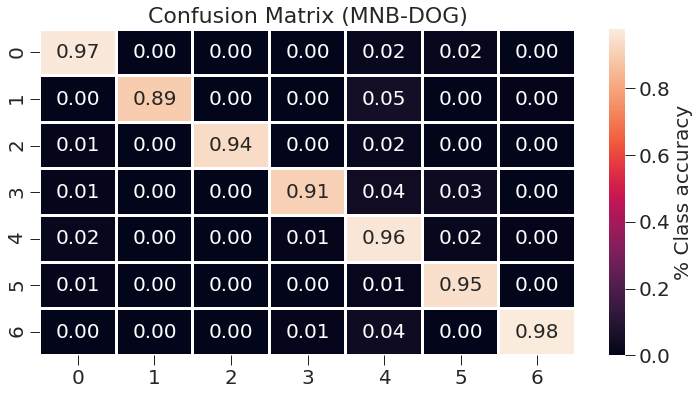

In [32]:
y_pred_dog=mnb.predict(X_dog)
conf_mat = confusion_matrix(y_dog,y_pred_dog)
normalized_confusion_matrix(y_dog,conf_mat,'MNB','DOG')
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_dog)
print('Performace on the Dog sequence:')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Neural Network

In [33]:
from sklearn.neural_network import MLPClassifier
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

mlp = MLPClassifier(random_state=0,max_iter=2000).fit(X_train_scaled, y_train)
y_pred=mlp.predict(X_test_scaled)

print('Training set accuracy: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Test set accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Training set accuracy: 0.999
Test set accuracy: 0.963


In [34]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.999 
precision = 0.965 
recall = 0.963 
f1 = 0.964


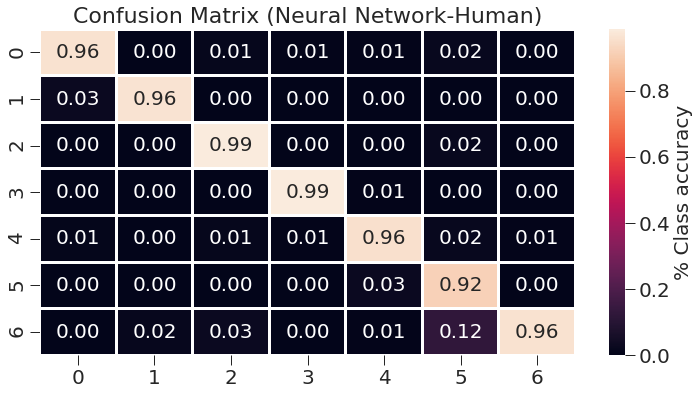

In [35]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'Neural Network','Human')

In [36]:
k_fold_mlp_accuracy = cross_val_score(mlp, scaler.fit_transform(X), y_human, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)) ##5-fold cross validation
k_fold_mlp_f1 = cross_val_score(mlp, scaler.fit_transform(X), y_human, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True), scoring='f1_macro') ##5-fold cross validation
print(f'Average accuracy after 5 fold cross validation : {k_fold_mlp_accuracy.mean().round(2)} +/- {k_fold_mlp_accuracy.std().round(2)}')
print(f'Average F1-score after 5 fold cross validation : {k_fold_mlp_f1.mean().round(2)} +/- {k_fold_mlp_f1.std().round(2)}')

Average accuracy after 5 fold cross validation : 0.96 +/- 0.0
Average F1-score after 5 fold cross validation : 0.96 +/- 0.01


### Predictions for the chimpanzee and dog dna sequences
#### Chimpanzee

Performace on the Chimpanzee sequence:
accuracy = 0.999 
precision = 0.986 
recall = 0.986 
f1 = 0.986


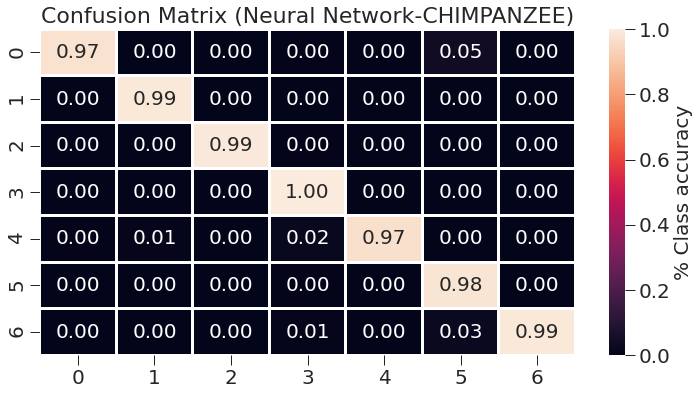

In [37]:
y_pred_chimp=mlp.predict(X_chimp)
conf_mat = confusion_matrix(y_chimp,y_pred_chimp)
normalized_confusion_matrix(y_chimp,conf_mat,'Neural Network','CHIMPANZEE')
accuracy, precision, recall, f1 = get_metrics(y_chimp, y_pred_chimp)
print('Performace on the Chimpanzee sequence:')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

#### DOG

Performace on the Dog sequence:
accuracy = 0.999 
precision = 0.938 
recall = 0.927 
f1 = 0.928


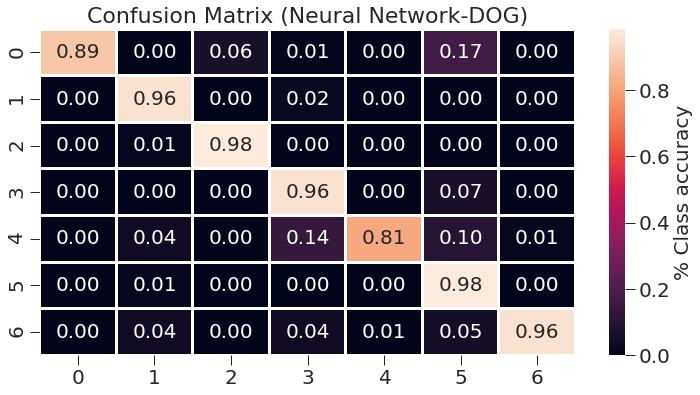

In [38]:
y_pred_dog=mlp.predict(X_dog)
conf_mat = confusion_matrix(y_dog,y_pred_dog)
normalized_confusion_matrix(y_dog,conf_mat,'Neural Network','DOG')
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_dog)
print('Performace on the Dog sequence:')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Model Comparison

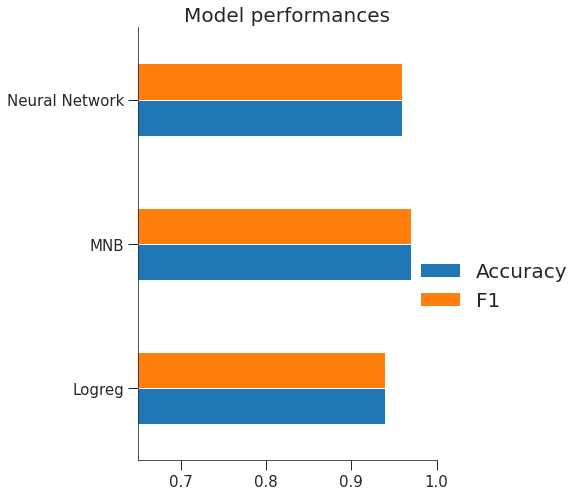

In [39]:
Accuracy = [k_fold_logreg_accuracy.mean().round(2),k_fold_mnb_accuracy.mean().round(2),k_fold_mlp_accuracy.mean().round(2)]
F1=[k_fold_logreg_f1.mean().round(2),k_fold_mnb_f1.mean().round(2),k_fold_mlp_f1.mean().round(2)]
model=['Logreg','MNB','Neural Network']
model_data=pd.DataFrame([Accuracy,F1],columns=model,index=['Accuracy','F1']).T
model_data[['Accuracy','F1']].plot.barh(figsize=(10,7))
plt.legend(frameon=False,bbox_to_anchor=(1.5,0.5), prop={'size':20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim([0.65,1]);
plt.title('Model performances',size=20)
sns.despine(top=True)
plt.tight_layout()
plt.savefig('model-comparision.png',dpi=300)

# Conclusions

- `Multinomial Naive Bayes` algorithm seems to provide the better performance than logistic regression and neural network based on 5-fold cross validation of the dataset and also achieves a higher F1-score as well, which is better metric for model evalution.
- The model seems to perform well on human data and also does well on chimpanzee as chimpanzee and human are similar genetically. 
- The performance on dog data is not quite as good since the dogs are more divergent from human genetically than the chimpanzee.